In [0]:
from matplotlib.colors import rgb_to_hsv , hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 1 
une fonction read_im(fn) qui permet de lire une image et de la renvoyer sous forme d’un numpy.array (utilisez plt.imread(fn) pour lire un fichier image)

In [0]:

def read_im(fn):
    """fonction pour lire une image
      entrées : 
        fn : chemin de l'image
      sorties:
        image en hsv converties en [-1,1]
    """
    image = plt.imread(fn)
    imagehsv = rgb_to_hsv(image)
    final = 2*(imagehsv /255.0) - 1# make the image [-1, 1]
    return final
    

# 2
• une fonction pour l’affichage de l’image (et des pixels manquants) - en utilisant plt.imshow

In [0]:
def print_im(image):
    """fonction pour afficher une image
      entrées : 
        image : numpy array d'une image en hsv converties en [-1,1].
    """
    image = 255.0*(image+1)/2# restore image to 0 255
    tworgb = hsv_to_rgb(image)
    plt.imshow(tworgb.astype(int))
    plt.show()

# 3 
• une fonction get_patch(i,j,h,im) qui permet de retourner le patch centré en (i, j) et de longueur h d’une image im ;

In [0]:
def get_patch(i,j, h, im):
    """
      fonction pour renvoyer un patch
      entrées : 
        i,j : centre du patch
        h : coté du patch
        im : l'image (array numpy) 
      sorties:
        array numpy de shape (h,h,3)
    """
    return im[i-int(h/2): i+ int(h/2), j-int(h/2): j+ int(h/2), :]

# 4 
des fonctions de conversions entre patchs et vecteurs ;

In [0]:
def patch2Vector(patch):
    """fonction pour transformer un patch en vecteur
      entrées : 
        patch : np array de shape (h,h,3)
      sorties:
        np array de shape (3h²)"""
    
    return patch.reshape(-1)
def vector2Patch(vector):
    """fonction pour transformer un vecteur en patch
      entrées : 
        patch : np array de shape (3h²)
      sorties:
        np array de shape (h,h,3)"""
    
    h = int(np.sqrt(vector.shape[0] / 3))
    return vector.reshape(h,h,3)

# 5 
des fonctions pour bruiter l’image originale : par exemple, noise(img,prc) qui permet de supprimer au hasard un pourcentage de pixel dans l’image, delete_rect(img,i,j,height,width)
qui permet de supprimer tout un rectangle de l’image ;

In [0]:
def noise(im, prc):
    """fonction pour buiter une image
      entrées : 
        im : np array de l'image.
        prc : pourcentage de cellules supprimées.
      sorties:
        np array de meme shape que im mais bruitée"""
    
    coords = [np.random.randint(0, i - 1, int(prc * im.shape[0] * im.shape[1] )) for i in im.shape[0:2]]
    image = im.copy()
    image[coords[0], coords[1], :] = -100
    return image

In [0]:
def delete_rec(img, i,j,height, width):
    """fonction pour supprimer un rectangle d'une image
      entrées : 
        im: np array de l'image
        i,j : centre du rectangle
        height, width : dimension du rectangle
      sorties:
        np array de l'image mais avec le rectangle vide"""
    
    im = img.copy()
    im[i-height//2: i+ height//2, j - width//2 : j+ width//2,:] = -100
    return im

# 6 
une fonction qui permet de renvoyer les patchs de l’image qui contiennent des pixels manquants ;

In [0]:
def get_missing(im, h):
    """fonction pour renvoyer les patchs dont le centre est manquant
      entrées : 
        im : np array de l'image
        h : dimension du patch 
      sorties:
        np array de shape (nombre de points manquants, 3*h²)"""
    
    points = np.argwhere(im[:,:,0] == -100)
    patches = []
    for i,j in points:
        tmp = im[max(0,i-h//2):min(i+h//2, im.shape[0]), max(0, j-h//2): min(im.shape[1], j+h//2), :]
        if tmp.shape == (h,h,3):
            patches.append(tmp.reshape(-1))
    return np.array(patches)

# 7 
 une fonction qui permet de renvoyer le dictionnaire, i.e. les patchs qui ne contiennent aucun pixel
manquant

In [0]:
def get_dict(im, step, h):
    """fonction pour avoir le dictionnaire des patchs complets
      entrées : 
        im : np array de l'image
        h : dimension du patch 
        step : pas de la grille
      sorties:
        np array de shape (nombre de patchs dans le dico, 3*h²)"""
    
    dictionnary = []
    grid = np.meshgrid(np.arange(0,im.shape[0], step, dtype=int),np.arange(0,im.shape[1], step, dtype=int))
    grid = np.hstack((grid[0].reshape(-1,1), grid[1].reshape(-1,1)))
    for i,j in grid:
        temp = im[max(0, i-h//2): i+h//2, max(0, j-h//2): j+h//2, :]
        if temp.shape == (h, h, 3) and (temp != -100).all():
            dictionnary.append(temp.reshape(-1))
    return np.array(dictionnary)

# 8
fonction qui prend un patch et un dictionnaire en entrée, et qui rend le vecteur de
poids sur le dictionnaire qui approxime au mieux le patch (restreint aux pixels exprimés) en utilisant
l’algorithme du LASSO

In [0]:
from sklearn import linear_model
def learn(dictionnary, patch, l):
    """fonction pour apprendre un modele LASSO
      entrées : 
        dictionnary : dictionnaire
        patch : le patch cible
        l : lambda
      sorties:
        le modele entrainé"""
    
    features = dictionnary[:, patch != -100].T
    target = patch[patch != -100]
    lasso = linear_model.Lasso(alpha=l)
    lasso.fit(features, target)
    return lasso

# bruit
Dans cette partie, on montre l'execution de l'algorithme 

In [0]:
image = read_im("texture.jpeg") # on choisi un image

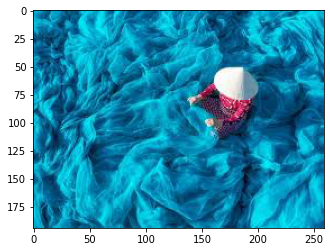

In [319]:
print_im(image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


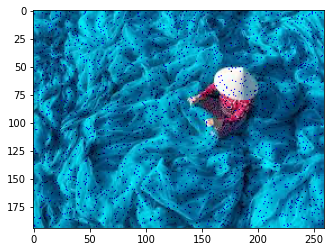

In [329]:
noised = noise(image, 0.05) # on bruite 5% des pixels
print_im(noised)
plt.show()

In [0]:
dictionnary = get_dict(image, 5, 6) # le dictionnaire

In [0]:
missing_patchs = get_missing(noised, 6) # les patchs manquants
patch = missing_patchs[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


============patch avec vides==============


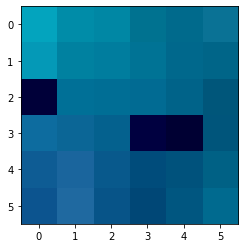

============reconstructed patch ==========


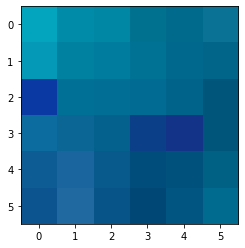

In [337]:
print("============patch avec vides==============")
patchCopy = patch.copy()
plt.clf()
print_im(vector2Patch(patchCopy))
plt.show()# on montre l'image avant
lasso = learn(dictionnary ,patch, 0.0001)# entrainement
predicted = lasso.predict(dictionnary[:,patch == -100].T)# on reconstruits les pixels non exprimés
patchi = patch.copy()
patchi[patchi == -100] = predicted # on attribue les valeurs predites
new = vector2Patch(patchi)
print("============reconstructed patch ==========")
print_im(new)

## tests

In [0]:
# test boucle de test
# modifié pour chaque test qu'on a effectué
norm, number = [], []
for l in np.linspace(0.0001,1, 30):
    n, num = 0,0
    for patch in missing_patchs[0 : 60]:
        lasso = learn(dictionnary ,patch, l)
        n += np.absolute(lasso.coef_).sum()
        num += (lasso.coef_ == 0).mean()
        del lasso
    norm.append(n / 20)
    number.append(num/20)
        
    
    

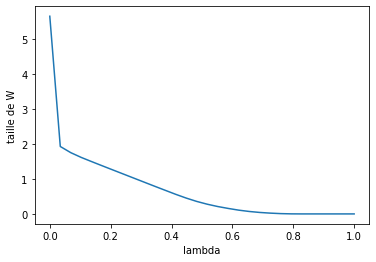

In [0]:
# taille de W
plt. plot(np.linspace(0.0001,1, 30), norm)
plt.ylabel("taille de W")
plt.xlabel("lambda")
plt.show()


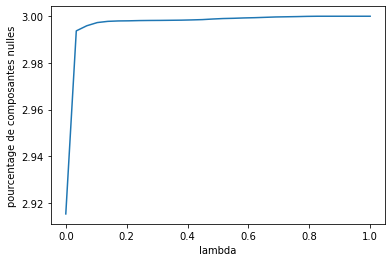

In [0]:
# composantes nulles
plt.plot(np.linspace(0.0001,1, 30),number )
plt.ylabel("pourcentage de composantes nulles")
plt.xlabel("lambda")
plt.show()

# partie d'image vide
Ici on traite la question sur la completion d'une image dont une partie est manquante

In [0]:
def reconstruct(deleted, dictionnary,h):
    """fonction pour remplir les zones vides d'une image
      entrées : 
        deleted : np array de l'image dont des zones sont supprimées
        h : dimension du patch 
        dictionnary : dictionnaire
      sorties:
        np array de shape de l'image"""
    
  while(deleted == -100).any():
    points = np.argwhere(deleted[:,:,2] == -100)# les i et j et valeurs manquantes
    north = points[:,0] ==  points[:,0].min() #bordure nord
    south = points[:,0] ==  points[:,0].max() #sub
    west =  points[:,1] ==  points[:,1].min() # ouest
    east =  points[:,1] ==  points[:,1].max() # est
    border = points[north | south| east| west][::h//3] # on visite h// 3 des points
    print(border.shape)
    for i,j in border:
        print(i,j)
        patch = deleted[i-h//2: i+h//2, j-h//2:j+h//2,:]# le patch
        if(patch == -100).any(): # si il a une valeurs manquante
          vector = patch2Vector(patch) # vectorisation
          lasso = learn(dictionnary, vector, 0.01) # entrainement
          predicted = lasso.predict(dictionnary[:,vector == -100].T)# predicion
          vector[vector == -100] = predicted # attribution
          deleted[i-h//2: i+h//2, j-h//2:j+h//2,:] = vector2Patch(vector) # changement dans l'image
          del vector # supression des variables pour ne pas encombrer la memoire
          del lasso
          del predicted
        del patch
  return deleted

    
    


exemple 1 : girls in a field

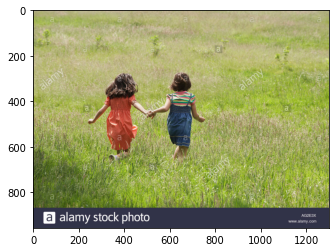

In [339]:
image = read_im("girls_field.jpg")
print_im(image)
plt.show()

<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


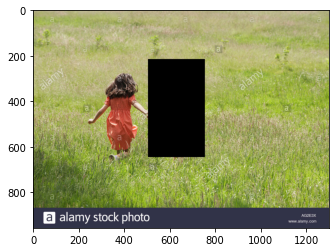

In [340]:
deleted = delete_rec(image, 430,630,430,250)
plt.clf()
plt.show()
print_im(deleted)
plt.show()

In [0]:
h=30 
dictionnary = get_dict(deleted, 15, h)

In [0]:
redone = reconstruct(deleted, dictionnary,h) # reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


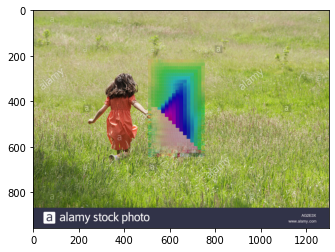

In [280]:
plt.show()
print_im(redone)
plt.show()

homme chute d'eau

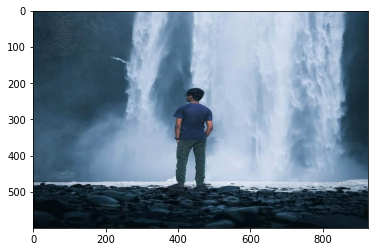

In [300]:
image = read_im("man.jpg")
print_im(image)
plt.show()

<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


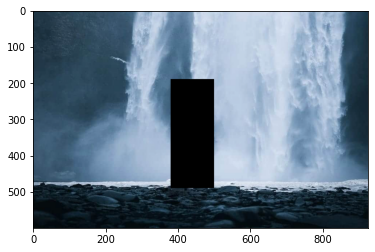

In [302]:
deleted = delete_rec(image, 340,440,300,120)
plt.clf()
plt.show()
print_im(deleted)
plt.show()

In [0]:
h=50
dictionnary = get_dict(deleted, 25, h)

In [0]:
redone = reconstruct(deleted, dictionnary,h)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


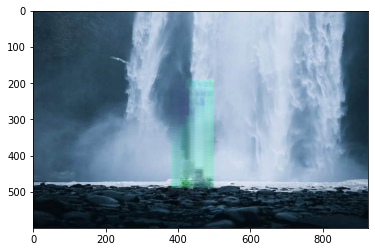

In [260]:
plt.show()
print_im(redone)
plt.show()

bateau horizon

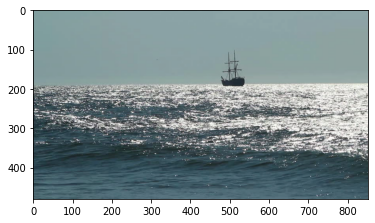

In [95]:
image = read_im("lone_ship.jpg")
print_im(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


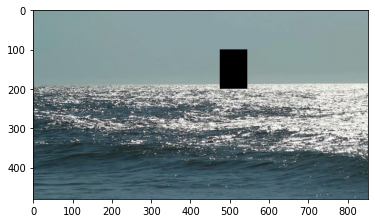

In [99]:
deleted = delete_rec(image, 150,510,100,70)
plt.show()
print_im(deleted)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


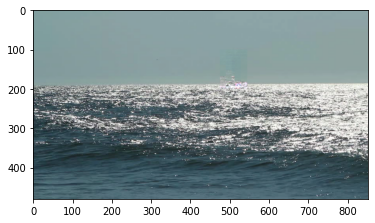

In [100]:
h=30
dictionnary = get_dict(deleted, 15, h)
redone = reconstruct(deleted, dictionnary,h)
plt.show()
print_im(redone)
plt.show()

texture

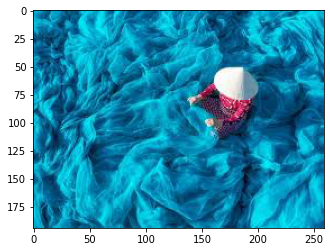

In [122]:
image = read_im("texture.jpeg")
print_im(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


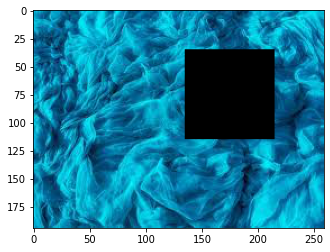

In [124]:
deleted = delete_rec(image, 75,175,80,80)
plt.show()
print_im(deleted)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


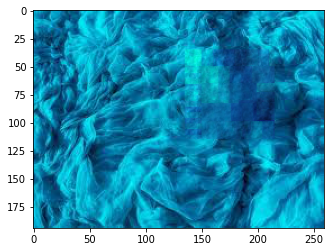

In [125]:
h=30
dictionnary = get_dict(deleted, 10, h)
redone = reconstruct(deleted, dictionnary,h)
plt.show()
print_im(redone)
plt.show()